In [5]:
import stela_toolkit as stela
import numpy as np
import matplotlib.pyplot as plt
import pylag
from scipy.signal import convolve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


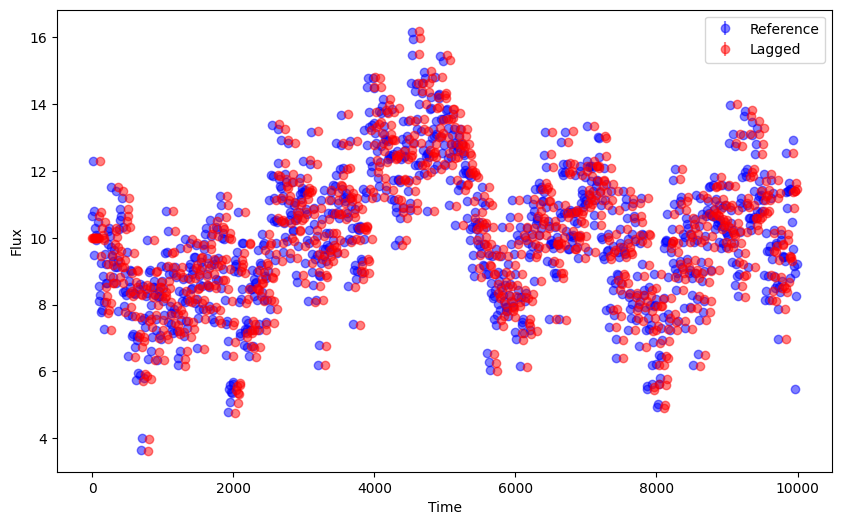

In [6]:
# Set simulation parameters
dt = 10.0
tmax = 10000.0
time_grid = np.arange(0, tmax, dt)
time_lag = 100.0

sim = stela.SimulateLightCurve(
    time_grid=time_grid,
    psd_type='powerlaw',
    psd_params={'slope': 2.0, 'plnorm': 1.0},
    mean=10.0,
    std=2.0,
    oversample=100,
    add_noise=False,
    bkg_rate=0.0,
    inject_lag=True,
    response_type='delta',
    response_params={'lag': time_lag}
)

lc1 = sim.simlc
lc2 = sim.simlc_lagged

plt.figure(figsize=(10, 6))
plt.errorbar(lc1.times, lc1.rates, yerr=lc1.errors, 
             fmt='o', label="Reference", alpha=0.5, color='blue')
plt.errorbar(lc2.times, lc2.rates, yerr=lc2.errors, 
             fmt='o', label=f"Lagged", alpha=0.5, color='red')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()


RuntimeWarning caught:
  > invalid value encountered in sqrt
Error from sqrt when computing (unbinned) phase errors here is common and typically due to >1 coherence at the minimum frequency.


/home/clewin/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/clewin/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_727/170333705.py:38: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(cs_py.freq, np.angle(cs_py.crossft)/(2*np.pi*cs_py.freq), fmt='o', label='pylag')


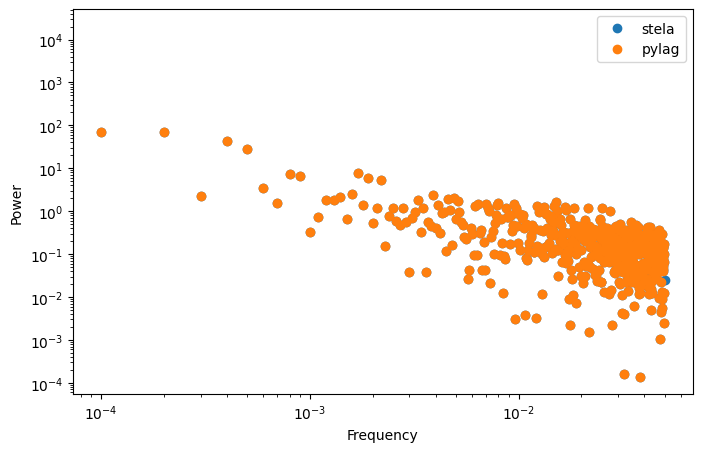

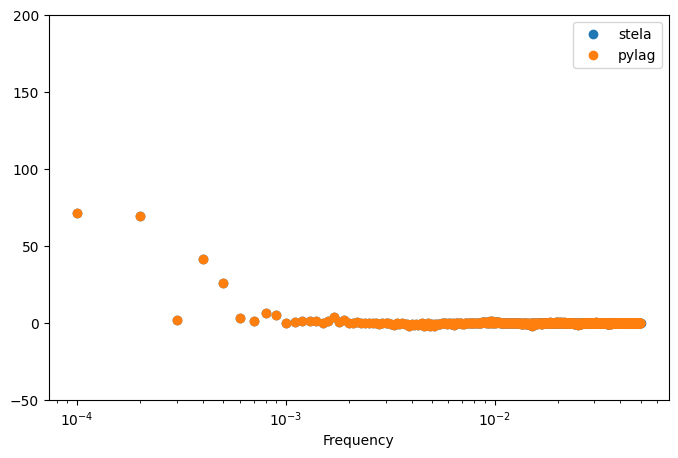

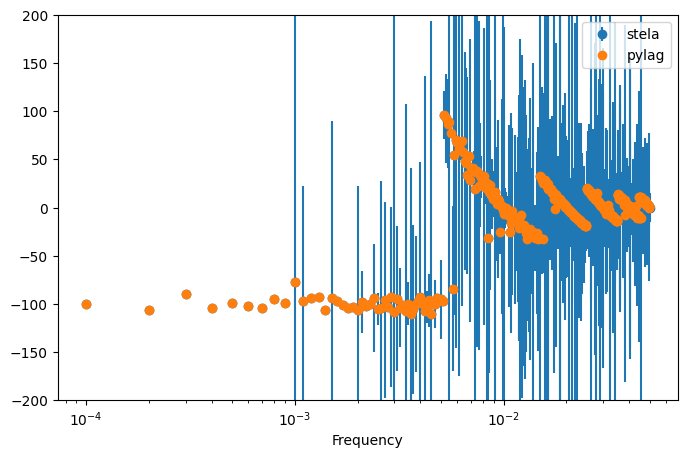

In [7]:
# Pylag expects pylag.LightCurve objects
lc1_py = pylag.LightCurve(t=lc1.times, r=lc1.rates)
lc2_py = pylag.LightCurve(t=lc2.times, r=lc2.rates)

# Compute unbinned results from pylag
psd_py = pylag.Periodogram(lc=lc1_py, norm=True)
cs_py = pylag.CrossSpectrum(lc1_py, lc2_py)

# Compute unbinned results from stela
lc1_stela = stela.LightCurve(lc1.times, lc1.rates)
lc2_stela = stela.LightCurve(lc2.times, lc2.rates)
psd_stela = stela.PowerSpectrum(lc1_stela, norm=True)
cs_stela = stela.CrossSpectrum(lc1_stela, lc2_stela)
lfs_stela = stela.LagFrequencySpectrum(lc1_stela, lc2_stela)

# Plot PSD comparison
plt.figure(figsize=(8, 5))
plt.errorbar(psd_stela.freqs, psd_stela.powers, fmt='o', label='stela')
plt.errorbar(psd_py.freq, psd_py.periodogram, psd_py.error, fmt='o', label='pylag')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.legend()

# Plot cross spectrum comparison
plt.figure(figsize=(8, 5))
plt.errorbar(cs_stela.freqs, cs_stela.cs, fmt='o', label='stela')
plt.errorbar(cs_py.freq, cs_py.crossft, fmt='o', label='pylag')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylim([-50, 200])
plt.legend()

# Plot lag-frequency comparison
plt.figure(figsize=(8, 5))
plt.errorbar(lfs_stela.freqs, lfs_stela.lags, lfs_stela.lag_errors, fmt='o', label='stela')
plt.errorbar(cs_py.freq, np.angle(cs_py.crossft)/(2*np.pi*cs_py.freq), fmt='o', label='pylag')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylim([-200, 200])
plt.legend()


RuntimeWarning caught:
  > invalid value encountered in sqrt
Error from sqrt when computing (unbinned) phase errors here is common and typically due to >1 coherence at the minimum frequency.
Coherence (stela): [5.02010483e+03 1.32825744e+03 6.10871120e+02 9.54511483e+00
 8.65746022e+00 5.62753043e-01 2.08003719e-01 2.52475679e-02
 5.19385173e-03 2.62371898e-04]
Lag errors (stela): [        nan         nan         nan         nan         nan  7.11314982
  6.14486087  7.7044257   6.77574257 11.89391015]
RuntimeWarning caught:
  > invalid value encountered in sqrt
Error from sqrt when computing (unbinned) phase errors here is common and typically due to >1 coherence at the minimum frequency.


/home/clewin/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/clewin/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/clewin/.local/lib/python3.12/site-packages/numpy/ma/core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


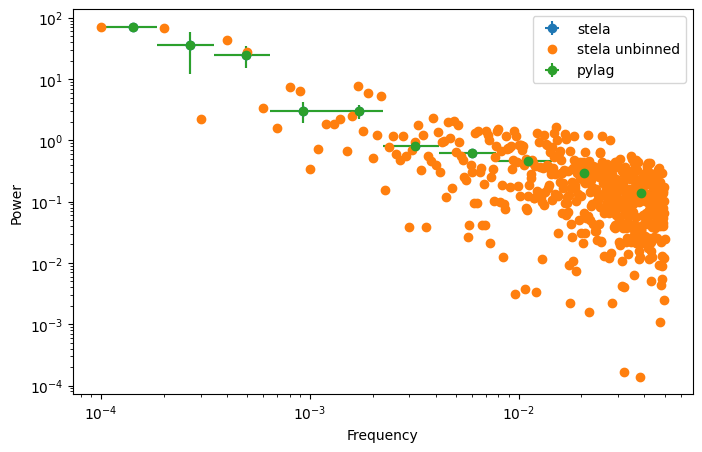

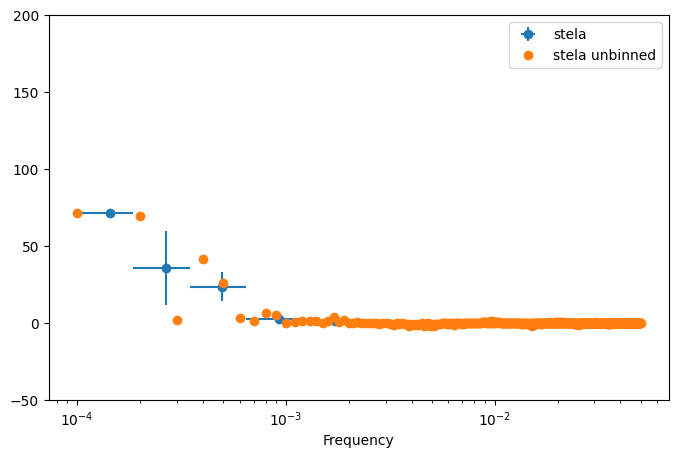

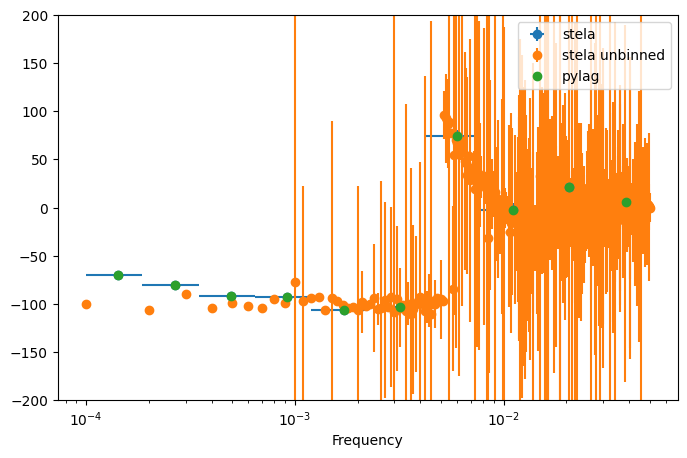

In [8]:
# Set up frequency binning for pylag
bins_py = pylag.LogBinning(0.0001, 0.05, num=10)

# Pylag binned results
psd_py = pylag.Periodogram(lc=lc1_py, norm=True).bin(bins_py)
cs_py = pylag.CrossSpectrum(lc1_py, lc2_py).bin(bins_py)
lags_py = np.angle(cs_py.crossft) / (2 * np.pi * cs_py.freq)

# STELA binned and unbinned results
num_bins = 10
psd_stela = stela.PowerSpectrum(lc1_stela, num_bins=num_bins, bin_type='log', norm=True)
psd_stela_unbinned = stela.PowerSpectrum(lc1_stela, norm=True)
cs_stela = stela.CrossSpectrum(lc1_stela, lc2_stela, num_bins=num_bins)
lfs_stela = stela.LagFrequencySpectrum(lc1_stela, lc2_stela, num_bins=num_bins)

print("Coherence (stela):", lfs_stela.cohs)
print("Lag errors (stela):", lfs_stela.lag_errors)

cs_stela_unbinned = stela.CrossSpectrum(lc1_stela, lc2_stela)
lfs_stela_unbinned = stela.LagFrequencySpectrum(lc1_stela, lc2_stela)

# Plot PSDs
plt.figure(figsize=(8, 5))
plt.errorbar(psd_stela.freqs, psd_stela.powers, xerr=psd_stela.freq_widths,
             yerr=psd_stela.power_errors, fmt='o', label='stela')
plt.errorbar(psd_stela_unbinned.freqs, psd_stela_unbinned.powers,
             fmt='o', label='stela unbinned')
plt.errorbar(psd_py.freq, psd_py.periodogram, xerr=psd_py.freq_error,
             yerr=psd_py.error, fmt='o', label='pylag')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.legend()

# Plot cross spectra
plt.figure(figsize=(8, 5))
plt.errorbar(cs_stela.freqs, cs_stela.cs, xerr=psd_stela.freq_widths,
             yerr=cs_stela.cs_errors, fmt='o', label='stela')
plt.errorbar(cs_stela_unbinned.freqs, cs_stela_unbinned.cs,
             yerr=cs_stela_unbinned.cs_errors, fmt='o', label='stela unbinned')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylim([-50, 200])
plt.legend()

# Plot lag-frequency spectra
plt.figure(figsize=(8, 5))
plt.errorbar(lfs_stela.freqs, lfs_stela.lags, xerr=psd_stela.freq_widths,
             yerr=lfs_stela.lag_errors, fmt='o', label='stela')
plt.errorbar(lfs_stela_unbinned.freqs, lfs_stela_unbinned.lags,
             yerr=lfs_stela_unbinned.lag_errors, fmt='o', label='stela unbinned')
plt.errorbar(cs_py.freq, lags_py, fmt='o', label='pylag')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylim([-200, 200])
plt.legend()

0.0001001001001001001


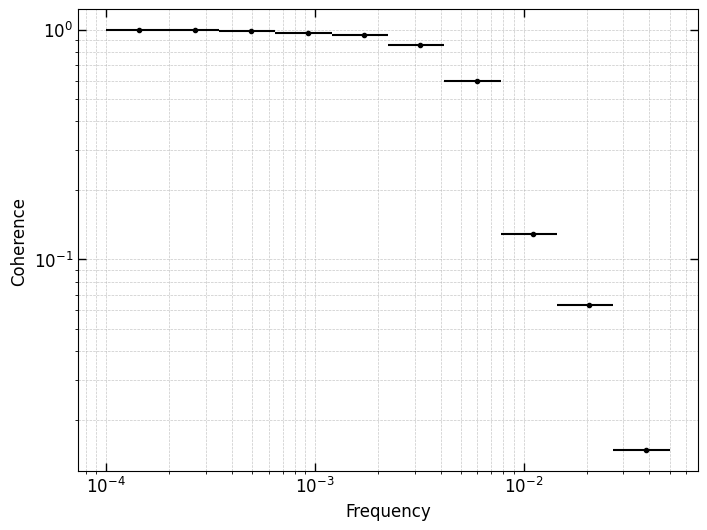

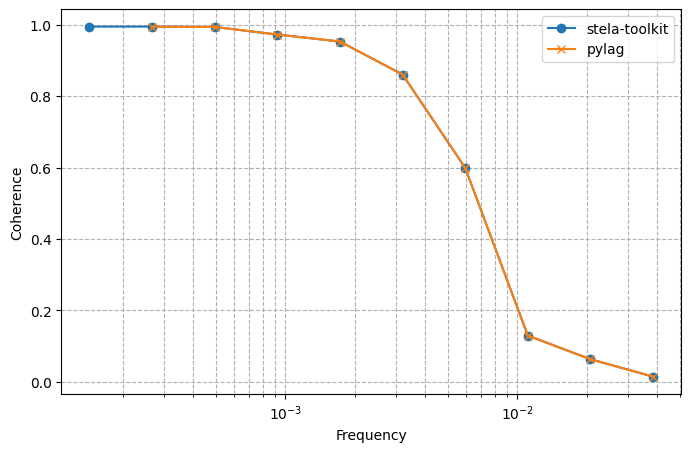

=== Coherence Numerical Difference ===
Mean Coherence Abs Diff: 5.3890705049514445e-05
Std Coherence Abs Diff: 6.299949011109816e-05


In [31]:
from pylag.binning import Binning
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Use the same time grid and settings
dt = lc1.times[1] - lc1.times[0]
fmin = 1 / (lc1.times[-1] - lc1.times[0])
print(fmin)
fmax = 1 / (2 * dt)

bins = pylag.LogBinning(fmin, fmax, num=10)
coh_stela = stela.Coherence(lc1, lc2, num_bins=10, bin_type='log', subtract_noise_bias=True)
coh_pylag = pylag.Coherence(lc1=lc1_py, lc2=lc2_py, bins=bins, bias=True)
coh_stela.plot()

plt.figure(figsize=(8,5))
plt.plot(coh_stela.freqs, coh_stela.cohs, marker='o', label='stela-toolkit')
plt.plot(coh_pylag.freq, coh_pylag.coh, marker='x', label='pylag')
plt.xlabel('Frequency')
plt.ylabel('Coherence')
plt.xscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()


interp_stela_coh = interp1d(coh_stela.freqs, coh_stela.cohs, bounds_error=False, fill_value=np.nan)
diff_coh = np.abs(interp_stela_coh(coh_pylag.freq) - coh_pylag.coh)

print("=== Coherence Numerical Difference ===")
print("Mean Coherence Abs Diff:", np.nanmean(diff_coh))
print("Std Coherence Abs Diff:", np.nanstd(diff_coh))